# Historical Returns Distribution fitting

## Normal or not

Before using the Volatility infered from the log-returns normality assumption, it is worth looking into the validity of that assumption.

Plotting the returns on a histogram and overlaying the fitted Normal distribution gives an easy graphical comparison of the appropriateness of the assumption of normality.

A few observations:
1. The actual returns around the mean (central peak) are much more frequent than the Normal
1. Those returns appear in a much narrower band around the mean
1. The returns outside the +/- 3-sigma band (the tails of the distribution) are hard to disthinguish

So 1. and 2. mean that there's more low amplitude returns in the data than would be if the returns were Normally distributed. 

Also good to note that these are within the +/- 3-sigma range where 99.7% of the normal returns would be. Given 262,980 2-minute time period per year, ~789 returns per year would be outside that range, so probably worth looking into it.





In [14]:

{
    "tags": [
        "hide_input",
    ]
}

import math

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

vol_2min = btcusd_1min['ret_2min'].std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


## Normal Distribution


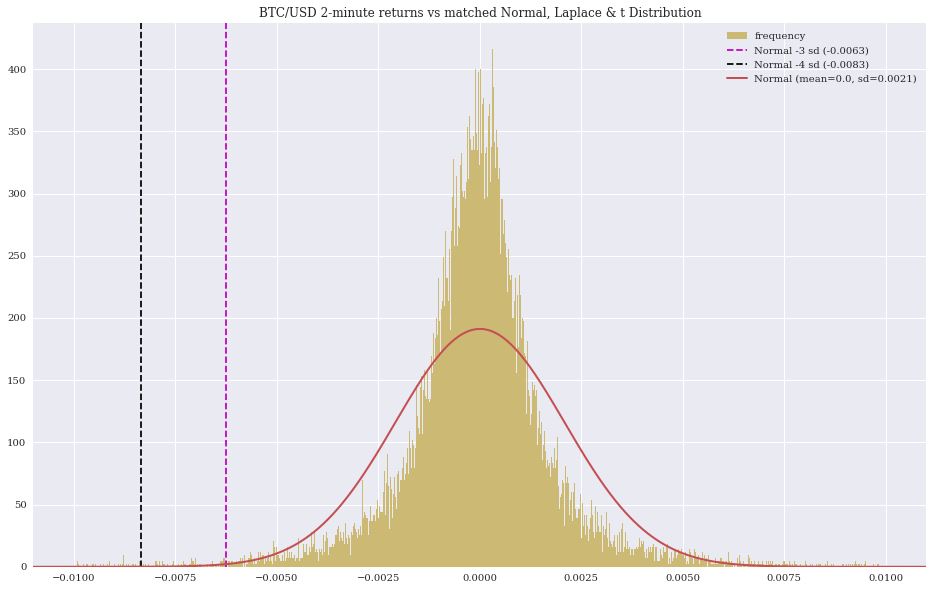

In [15]:

# nb_2min_in_30d = 30*24*60/2 # = 21600
ret_2min = btcusd_1min['ret_2min'][-21600:]
# ret_2min = btcusd_1min['ret_2min'][2:]

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);
# plt.axvline(mean + 4 * std, color='k', label='Normal +4 sd', linestyle='--')
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

# #  Plot the Laplace PDF.
# loc,scale = laplace.fit(ret_2min)
# l = laplace.pdf(x, loc, scale)
# plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc="best");
plt.show()

Plotting the same histogram in logarithmic scale allows to zoom in on the tails (also showing only the frequency increment to make it more readable.)

Looking at the left tail, passed the -3σ dotted line, the returns are much more frequent in than predicted by the Normal from ~1 to 2 orders of magnitude.

It means that extreme returns are more frequent and that volatility, as modeled by the standard deviation of normally distributed log-returns, is understated.
Also any use of that volatility, ex. for pricing an option, will be skewed.

So what can be done about it.


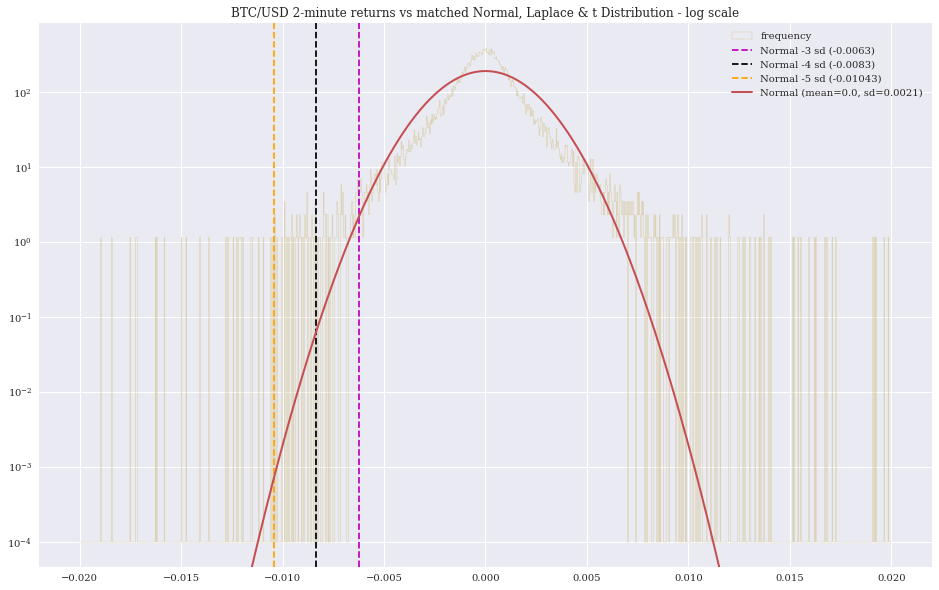

In [21]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
# plt.figure(figsize=(24, 15))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution - log scale")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.02,0.02], log=True, bottom=0.0001, histtype='step');
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')
plt.axvline(mean - 5 * std, color='orange', label=f'Normal -5 sd ({(mean - 5 * std).round(5)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

# #  Plot the Laplace PDF.
# loc,scale = laplace.fit(ret_2min)
# l = laplace.pdf(x, loc, scale)
# plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc='best');
plt.show()

## Laplace Distribution

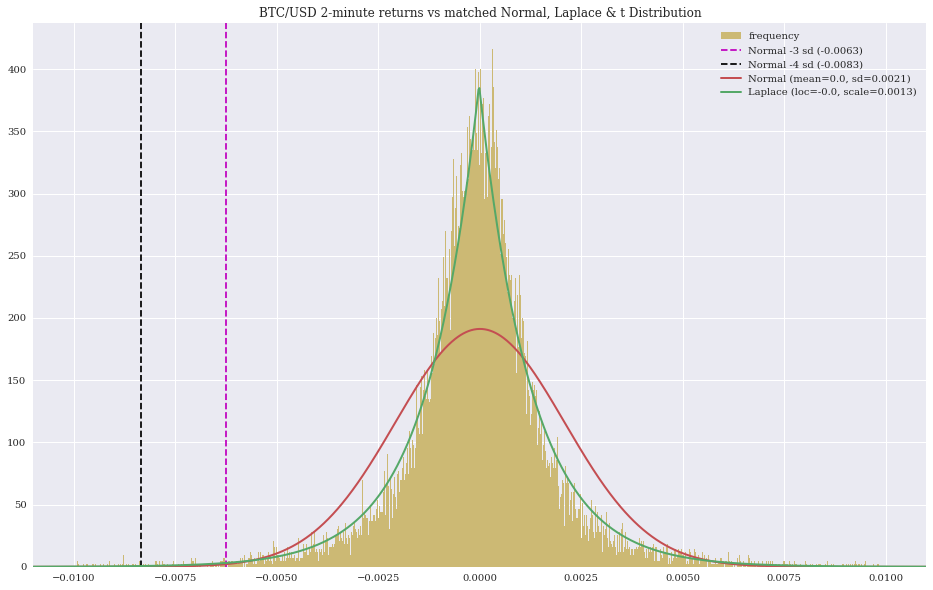

In [17]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc="best");
plt.show()

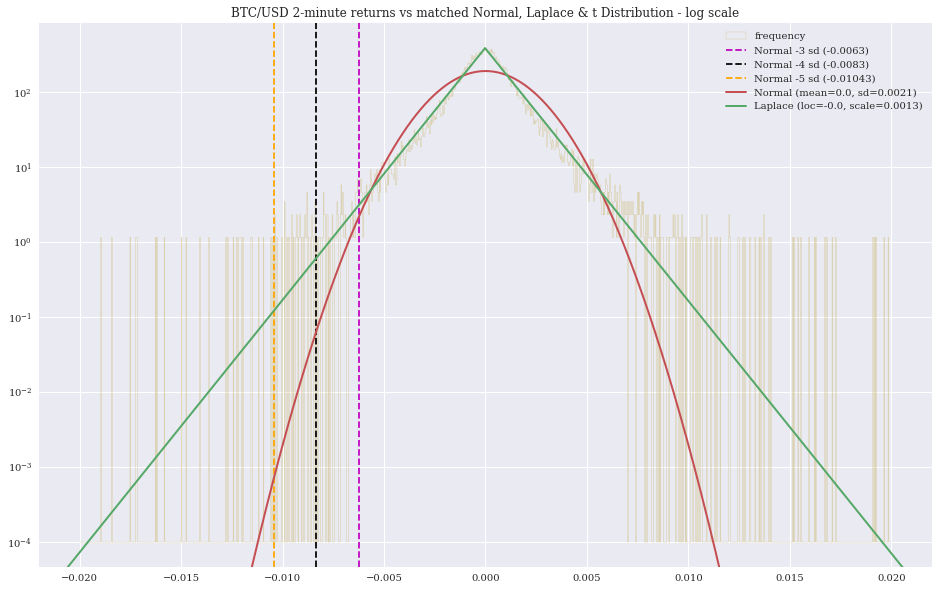

In [18]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
# plt.figure(figsize=(24, 15))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution - log scale")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.02,0.02], log=True, bottom=0.0001, histtype='step');
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')
plt.axvline(mean - 5 * std, color='orange', label=f'Normal -5 sd ({(mean - 5 * std).round(5)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc='best');
plt.show()

## Student's t Distribution

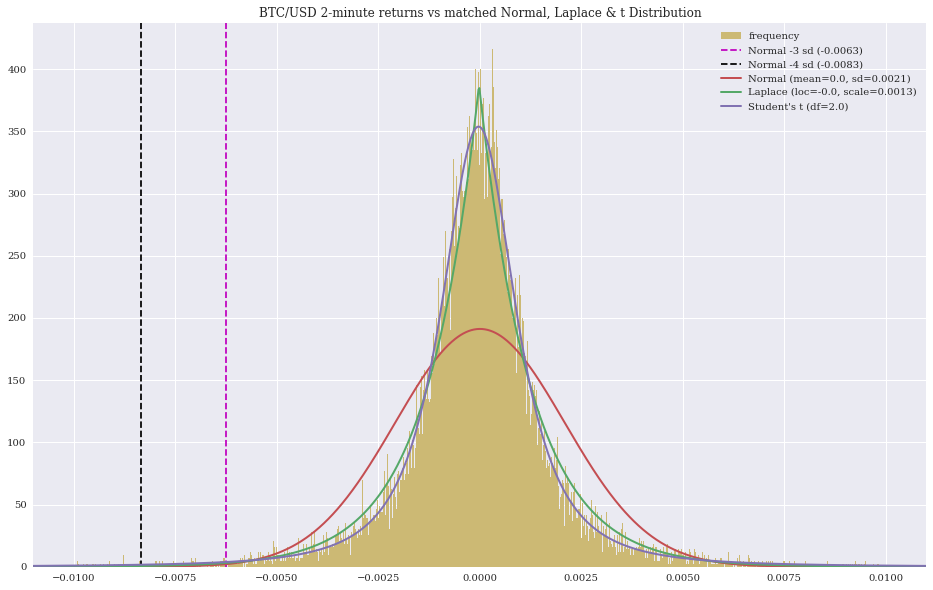

In [19]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

#  Plot the student-t PDF.
df, tloc, tscale = student_t.fit(ret_2min)
t = student_t.pdf(x, df, tloc, tscale)
plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc="best");
plt.show()

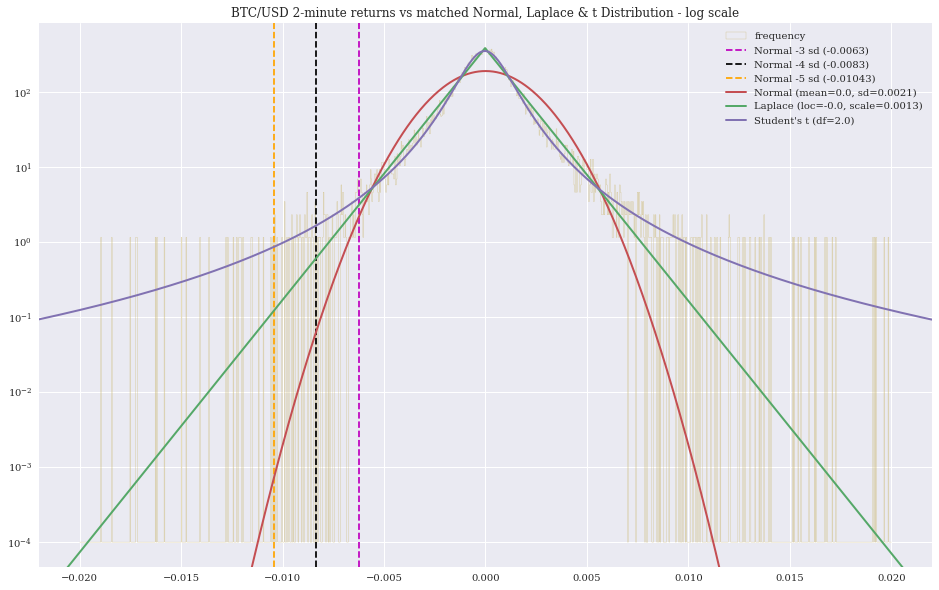

In [20]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution - log scale")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.02,0.02], log=True, bottom=0.0001, histtype='step');
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')
plt.axvline(mean - 5 * std, color='orange', label=f'Normal -5 sd ({(mean - 5 * std).round(5)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

#  Plot the student-t PDF.
df, tloc, tscale = student_t.fit(ret_2min)
t = student_t.pdf(x, df, tloc, tscale)
plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc='best');
plt.show()

## Lookback at the sigma levels